# Demonstration of bi-cross validation for determining spectral clustering parameters and cluster number

This work demonstrates how bi-cross validation descibred by Owen and Perry https://projecteuclid.org/euclid.aoas/1245676186 can be used to determine the number of clusters and hyper parameters used in spectral clustering.  This work extends the cluster number estimation performed here https://arxiv.org/abs/1702.02658 from k-means implementation for use in spectral clustering.

This notebook is organized into the following blocks

### 1) generate the data set

### 2) validate the sci-kit learn spectral clustering algorithm

### 3) validate sci-kit learn k-means on the diagonalizaed Laplacian

### 4) calculate the bi-cross value (BCV) loss function to estimate the number of clusters

### 5) calculate the bi-cross value (BCV) loss function to estimate gamma parameter


__________________________________________________________________________________________
__________________________________________________________________________________________
__________________________________________________________________________________________
__________________________________________________________________________________________

## importing libraries

In [1]:
from sklearn import cluster
from sklearn.cluster import KMeans
from sklearn import manifold
from sklearn.manifold import spectral_embedding
from sklearn import svm
from sklearn import datasets
from sklearn.base import BaseEstimator
from sklearn.utils import check_random_state, check_array, check_symmetric
from sklearn.utils.extmath import _deterministic_vector_sign_flip
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.neighbors import kneighbors_graph

from scipy import stats
from scipy import sparse
from scipy.linalg import eigh
from scipy.sparse.linalg import eigsh, lobpcg
from scipy.sparse.csgraph import connected_components
from scipy.sparse.csgraph import laplacian as csgraph_laplacian

from matplotlib import pyplot as plt
from importlib import reload

import scipy
import numpy as np

import matplotlib as mpl
import warnings
import random
import itertools
import lib
import inspect

from lib import bi_cross_support
from lib import spectral_cluster_support
reload(spectral_cluster_support)


<module 'lib.spectral_cluster_support' from '/reg/neh/home5/sioan/Desktop/git_version_controlled/bcv_spectral_clustering/lib/spectral_cluster_support.py'>

## 1) generating data set

In [2]:
#n_samples = 150
#random_state = 140
#n_centers = 4
#X = datasets.make_blobs(n_samples=n_samples, centers = n_centers,n_features=2,random_state=11,cluster_std=0.3)[0]
#X =np.vstack([X,np.array([6,-6])+4*datasets.make_moons(n_samples=n_samples, noise=.01)[0]])

x = np.array([])
y = np.array([])
z = np.array([])

t = 2*np.pi*np.arange(0,1,0.01)

for i in np.arange(6):
    x = np.append(x,i*1.5+np.sin(t)) 
    y = np.append(y,(1-((-1)**i))*np.cos(t)) 
    z = np.append(z,(1+(-1)**i)*np.cos(t)) 


x = np.append(x,np.arange(2,7,0.05))
#y = np.append(y,np.arange(2,4,0.1)*0+1.5)
y = np.append(y,5-0.5*(np.arange(2,7,0.05)-4.5)**2)
z = np.append(z,np.arange(2,7,0.05)*0)

X = np.array([x,y,z]).transpose()

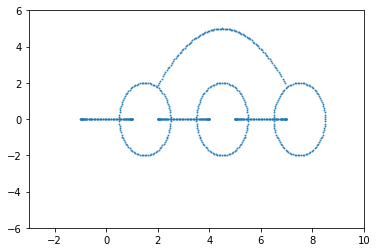

In [3]:
plt.scatter(X[:,0],X[:,1],alpha=0.8,s=1)
plt.xlim(-3,10)
plt.ylim(-6,6)
plt.show()

## 2) Validating that clustering algorithm correctly labels data sets

In [4]:
spectral = cluster.SpectralClustering(n_clusters=5,
                                      #random_state=30,
                                      gamma=100,
                                      #affinity = 'nearest_neighbors',
                                      affinity = 'rbf',
                                      n_init   = 100,
                                      #n_neighbors=8
                                      #gamma=1e2
                                     )
spectral.fit(X)

SpectralClustering(affinity='rbf', assign_labels='kmeans', coef0=1, degree=3,
          eigen_solver=None, eigen_tol=0.0, gamma=100, kernel_params=None,
          n_clusters=5, n_init=100, n_jobs=None, n_neighbors=10,
          random_state=None)

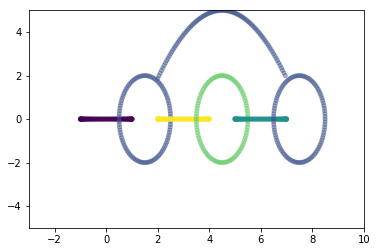

In [5]:
plt.scatter(X[:,0],X[:,1],c=spectral.labels_,alpha = 0.4,s=17)
plt.xlim(-3,10)
plt.ylim(-5,5)
plt.show()

## 3) Validating the understanding of how spectral clustering works by applying  kmeans of eigen decomposed laplcian matrix

The Laplacian matrix calculated by the sci-kit learn package is exposed by copying the spectral_embedding method located here

https://github.com/scikit-learn/scikit-learn/blob/3b35104c93cb53f67fb5f52ae2fece76ef7144da/sklearn/manifold/spectral_embedding_.py#L134

and modifying it as done here

https://github.com/sioan/bcv_spectral_clustering/blob/777097fe85326dcde3464f04f04affc9c90e4d9e/lib/spectral_cluster_support.py#L562


to return the laplacian matrix

https://github.com/sioan/bcv_spectral_clustering/blob/777097fe85326dcde3464f04f04affc9c90e4d9e/lib/spectral_cluster_support.py#L744-L747

In [6]:
laplacian,my_embedding = lib.spectral_cluster_support.get_laplacian(spectral.affinity_matrix_,
                                #n_components = spectral.n_clusters,
                                n_components = 5,
                                drop_first=True, 
                                eigen_solver = spectral.eigen_solver,
                                random_state = spectral.random_state)

in standard spectral clustering, the eigen vectors of the laplacian matrix are calculated

In [7]:
laplacian

array([[-1.        ,  0.37402754,  0.11408299, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.37402754, -1.        ,  0.37680417, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.11408299,  0.37680417, -1.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., -1.        ,
         0.49702687,  0.00418638],
       [ 0.        ,  0.        ,  0.        , ...,  0.49702687,
        -1.        ,  0.66726611],
       [ 0.        ,  0.        ,  0.        , ...,  0.00418638,
         0.66726611, -1.        ]])

In [8]:
eig_vals, eig_vecs = np.linalg.eig(laplacian)
eig_vals, eig_vecs = np.real(eig_vals), np.real(eig_vecs)

and then standard k-means clustering is performed 

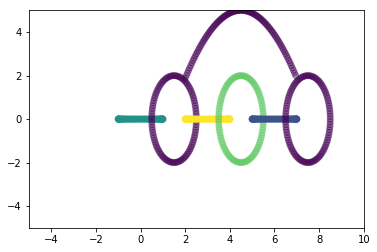

In [9]:
n_clusters=5
kmeans = KMeans(n_clusters=n_clusters).fit(eig_vecs[:,np.argsort(np.abs(eig_vals))][:,:n_clusters])

plt.scatter(X[:,0],X[:,1],c=kmeans.labels_,alpha = 0.4)
plt.xlim(-5,10)
plt.ylim(-5,5)
plt.show()


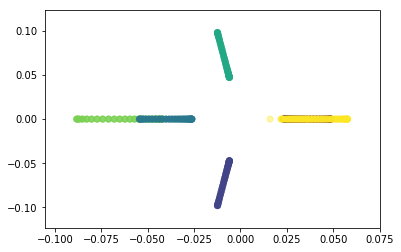

In [10]:
n_clusters=6
kmeans = KMeans(n_clusters=6).fit(eig_vecs[:,np.argsort(np.abs(eig_vals))][:,:n_clusters])

my_eigen_vectors = eig_vecs[:,np.argsort(np.abs(eig_vals))]

plt.scatter(my_eigen_vectors[:,2],my_eigen_vectors[:,3],c=kmeans.labels_,alpha = 0.4)
#plt.xlim(-5,10)
#plt.ylim(-5,5)
plt.show()


##  4) Calculating Bi-Cross Validation Loss Function to Estimate Number of Clusters

In this section the bi-cross validation loss function is calculated.  Once again, the Laplacian matrix is calculated by running the spectral.fit method.

In [13]:
spectral = cluster.SpectralClustering(n_clusters=5,                     #intentionally incorrect clusters
                                      assign_labels="discretize",
                                      #random_state=10,
                                      gamma=100.0,                        #this hyper parameter can estimated using BCV-Loss
                                      affinity = 'rbf')


spectral.fit(X)          #the affinity matrix is only calculated after the fit method is executed

SpectralClustering(affinity='rbf', assign_labels='discretize', coef0=1,
          degree=3, eigen_solver=None, eigen_tol=0.0, gamma=100.0,
          kernel_params=None, n_clusters=5, n_init=10, n_jobs=None,
          n_neighbors=10, random_state=None)

In the nxt part, The BCV loss function will be calculated as the number of eigen vectors is swept. The section after that the BCV loss function will be calculated while sweeping the gamma hyper parameter. The BCV loss function has a minimum at gamma parameter correctly estimates the number of clusters.

In [14]:
#using the modified sci-kit learn package to convert the affinity matrix
laplacian,my_embedding = lib.spectral_cluster_support.get_laplacian(spectral.affinity_matrix_,
                                #n_components = spectral.n_clusters,
                                n_components = X.shape[0]-2,
                                eigen_solver = spectral.eigen_solver,
                                random_state = spectral.random_state)

The source for calculating the BCV loss function used in SVD (i.e. the bi_cross_support.score function) is here
https://github.com/sioan/bcv_spectral_clustering/blob/261d4b9979eb9a8922f386a96beb2ed9fdcfcdbb/lib/bi_cross_support.py#L35-L47

In [15]:
n_interations=10
row_range = range(laplacian.shape[0])
col_range = range(laplacian.shape[1])
MSE_list = []
min_k = 1
max_k = 16
k_range = np.arange(min_k,max_k)
regularization_parameter= 1e-14
#my_matrix = 0+ y_stack

def condition_matrix(X,regularization_magnitude):
    my_rand_mat = stats.ortho_group.rvs(X.shape[0])
    my_rand_mat = my_rand_mat - np.dot( np.dot(my_rand_mat.transpose(),X),my_rand_mat)
    

    
    return X + regularization_magnitude*my_rand_mat


for j in np.arange(n_interations):
    #y_stack = 0+np.linalg.inv(laplacian+regularization_parameter*stats.ortho_group.rvs(laplacian.shape[0]))   #this might be working
    #print(j)
    y_stack = np.linalg.inv(condition_matrix(laplacian,regularization_parameter))
    
    row_shuffling = np.array(random.sample(row_range,len(row_range)))     
    col_shuffling = np.array(random.sample(col_range,len(col_range)))
    
    my_matrix =  y_stack[row_shuffling]           #shuffling is messing things up, and it's not clear why
    my_matrix =  my_matrix[:,col_shuffling]
    #my_matrix = 0+ y_stack

    temp_MSE_list=[]
    
    for k in k_range:
    

        
        temp_MSE_list.append(bi_cross_support.score(my_matrix,
                                   k=k,
                                   d_n_rows=int(30), #y_stack.shape[0]/2
                                   d_n_cols=int(30), #y_stack.shape[0]/2
                                   SVD_package='numpy'))
        
    MSE_list.append(temp_MSE_list)

In [16]:
median_MSE_list = np.median(np.array(MSE_list),axis=0)
mean_MSE_list = np.mean(np.array(MSE_list),axis=0)
std_MSE_list = np.std(np.array(MSE_list),axis=0)/n_interations**0.5
print(k_range[np.argmin(median_MSE_list)])
print(k_range[np.argmin(mean_MSE_list)])

5
14


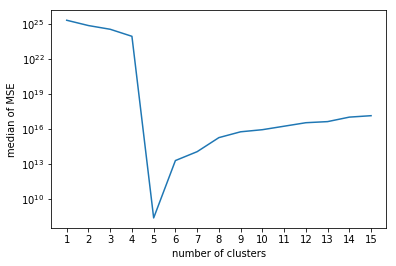

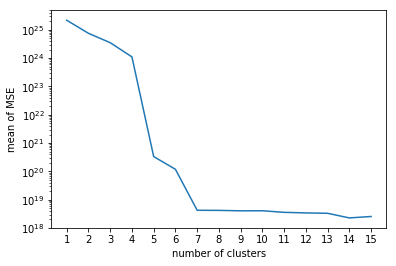

In [17]:
#plt.errorbar(np.arange(2,max_k),median_MSE_list,yerr=(std_MSE_list))
plt.semilogy(k_range,median_MSE_list)
#plt.ylim(0.9*np.min(median_MSE_list),1.25*np.min(median_MSE_list))
#plt.ylim(0,1e5)
plt.ylabel("median of MSE")
plt.xticks(k_range)
plt.xlabel("number of clusters")
plt.show()
plt.semilogy(k_range,mean_MSE_list)
#plt.errorbar(np.arange(2,max_k),mean_MSE_list,yerr=(std_MSE_list))
#plt.ylim(0.9*np.min(mean_MSE_list),1.25*np.min(mean_MSE_list))
plt.xticks(k_range)
plt.xlabel("number of clusters")
plt.ylabel("mean of MSE")
plt.show()